In [3]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score 
import math
import seaborn as sns
import shutil

In [4]:
import matplotlib as mpl
from matplotlib.pyplot import figure
#import matplotlib.pyplot as plt
#import numpy as np
#from pylab import cm

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1


In [3]:
# odk data for the evaluation and testing data 
media_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/media"
trees_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/Tree-Segmentation-tree.csv"
surveys_path = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/odk_data/Tree-Segmentation.csv"

In [4]:
trees = pd.read_csv(trees_path)
#trees.head()

In [5]:
surveys = pd.read_csv(surveys_path)
#surveys.head()

In [6]:
# filter surveys that were approved on odk central panel
testing_keys = surveys[surveys['ReviewState'] == 'approved']["KEY"].tolist()

def getTestingDataset(parent_key):
    if parent_key in testing_keys:
        return True
    else:
        return False

testing_trees = trees[trees.PARENT_KEY.apply(getTestingDataset)]

In [7]:
# number of images for testing 
tree_pictures = testing_trees['tree_picture'].tolist()
len(tree_pictures)

206

In [8]:
# Confirm which survey images are available for analysis
downloaded_images = []
for image in tree_pictures:
    if image in os.listdir(media_path):
        downloaded_images.append(image)

In [25]:
# generate complete path for tree images that exist
downloaded_image_paths = [os.path.join(media_path, image) for image in downloaded_images]

In [26]:
# functions to get dbh estimation for an image. The dbh estimation algorithm FastAPI must be running locally. 

def getDBH(temp_image, measured_dbh):
    try:

        url = f'http://127.0.0.1:8000/recognize/{measured_dbh}'

        file = {'uploaded_file': open(temp_image, 'rb')}

        r = requests.post(url, files=file)

        dbh = eval(r.text)['dbh']

        return dbh
        
    except:
        return None

In [27]:
# make a new dataframe with tree picture, and its location
df = pd.DataFrame({
    'tree_picture': downloaded_images,
    'image_path': downloaded_image_paths
})

In [28]:
# merge the dataframe from above with the orginal dataset to add the measured_dbh values
df= df.merge(trees[['tree_picture', 'tree_dbh', 'PARENT_KEY']], on='tree_picture')
#df.head()

In [5]:
# standardized dbh measurements. Some of the measurements were done with standard tape and others with diameter tapes. Make them all a diameter measurement
diameter = surveys[surveys['tape'] == 'diameter']['KEY'].tolist()
standard = surveys[surveys['tape'] == 'standard']['KEY'].tolist()


def getTape(parent_key):
    if parent_key in diameter:
        return "diameter"
    elif parent_key in standard:
        return "standard"
    else:
        return None

df['tape'] = df["PARENT_KEY"].apply(getTape)

def getMeasuredDBH(tree_dbh, tape):
    if tape == 'diameter':
        return tree_dbh
    elif tape == 'standard':
        return round(tree_dbh/math.pi, 2)
    else:
        return None

df['measured_dbh'] = df.apply(lambda x: getMeasuredDBH(x['tree_dbh'],x['tape']), axis=1)


NameError: name 'surveys' is not defined

In [30]:
# helper function to group data into buckets for dbh ranges
def getRange(dbh):
    if dbh < 5:
        return "0-05"
    elif dbh < 10:
        return "05-10"
    elif dbh < 15:
        return "10-15"
    elif dbh < 20:
        return "15-20"
    elif dbh < 25:
        return "20-25"
    elif dbh < 30:
        return "25-30"
    elif dbh < 35:
        return "30-35"
    elif dbh < 40:
        return "35-40"
    elif dbh < 45:
        return "40-45"
    elif dbh > 45:
        return "45+"


In [31]:
# apply helper function above on the measured dbh values
df['range'] = df.measured_dbh.apply(getRange)

In [32]:
# drop out dataset with no submission for tree image, or actual dbh measurement
df = df.dropna()
len(df)

205

Text(0, 0.5, 'Frequency')

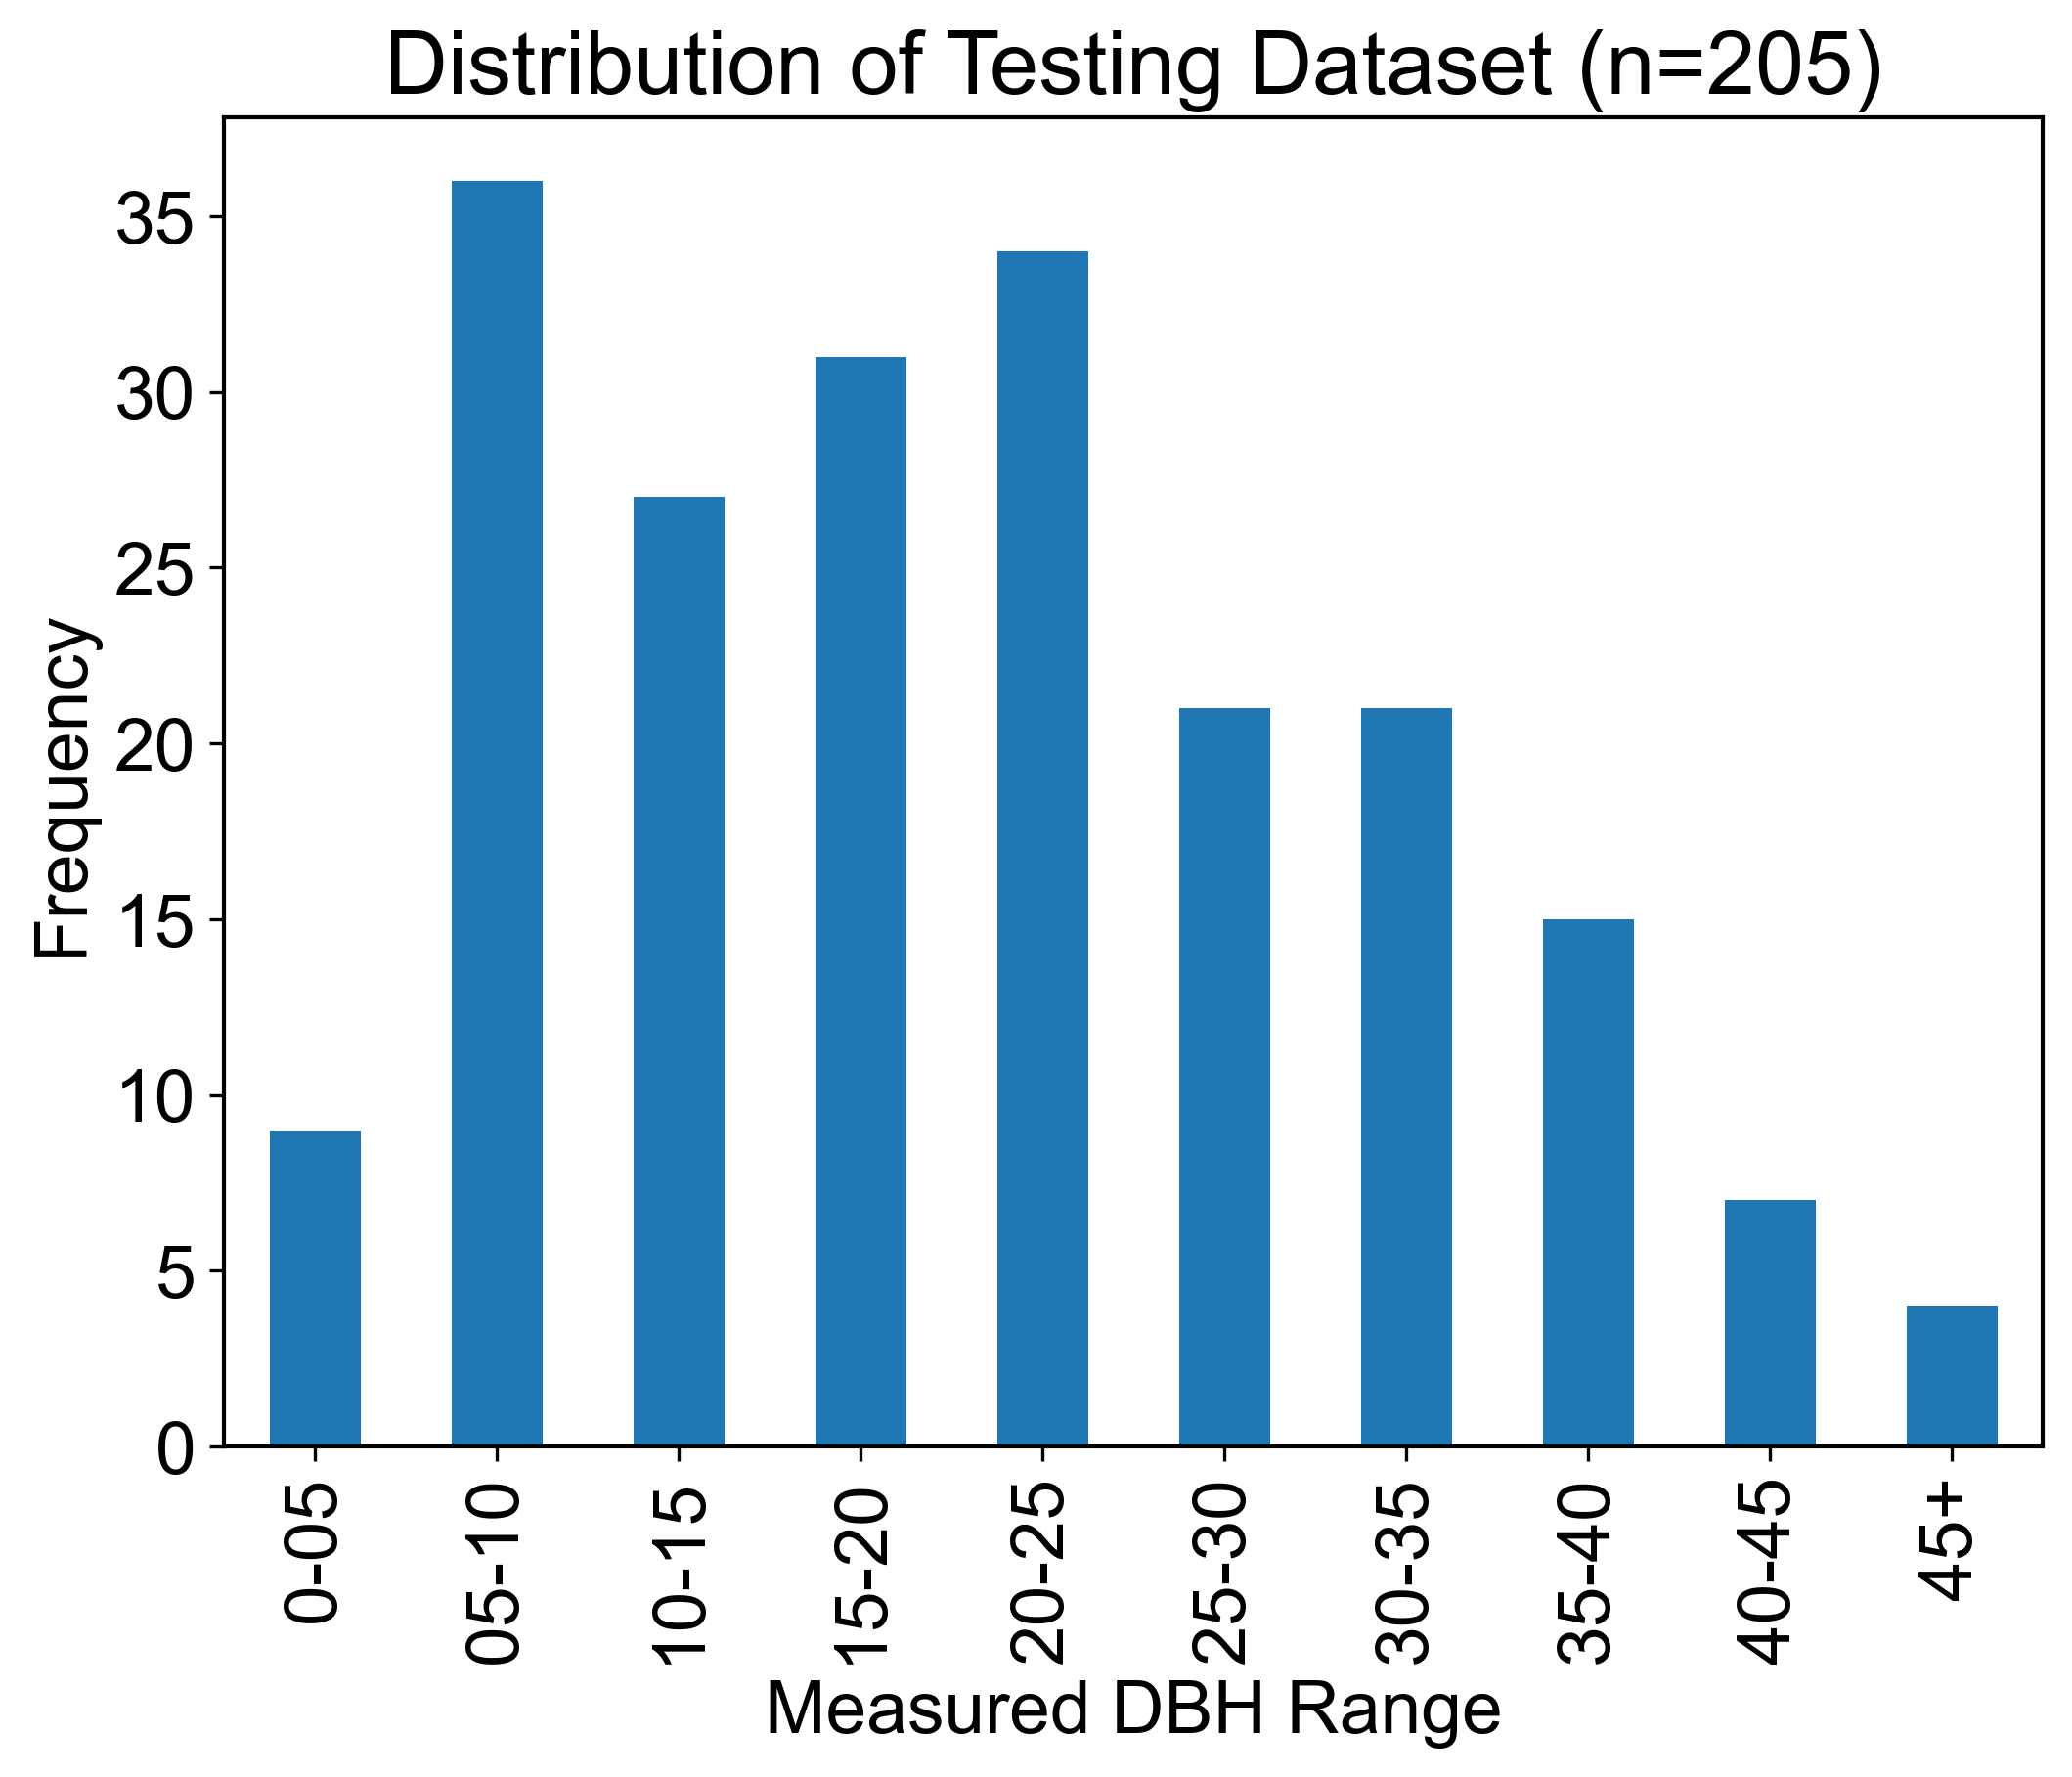

In [34]:
# Distribution of dataset
figure(figsize=(8, 6), dpi=300)
df.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Testing Dataset (n={len(df)})')
plt.xlabel("Measured DBH Range")
plt.ylabel("Frequency")

In [35]:
# This doesn't do anything important. I used it before to do some sampling experiments
df_sample = df #.sample(n=170) # sub-sample
#len(df_sample)

In [36]:
# filter out calibiration dataset 
# load file names of images that were used for calibrating the model to seperate them from the evaluation of the model
calibiration = os.listdir('/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/data/annotated_trees')
calibiration = [val for val in calibiration if "zoomed" in val]
calibiration = [val.split("_")[3]+".jpg" for val in calibiration]
len(calibiration)
# there are 52 images that were used for calibiration

52

In [37]:
# function to check if an image is in the calibration dataset
def isCalibirationData(tree_pic):
    if tree_pic in calibiration:
        return True
    return False

def isNotCalibirationData(tree_pic):
    return not isCalibirationData(tree_pic)

Text(0, 0.5, 'Frequency')

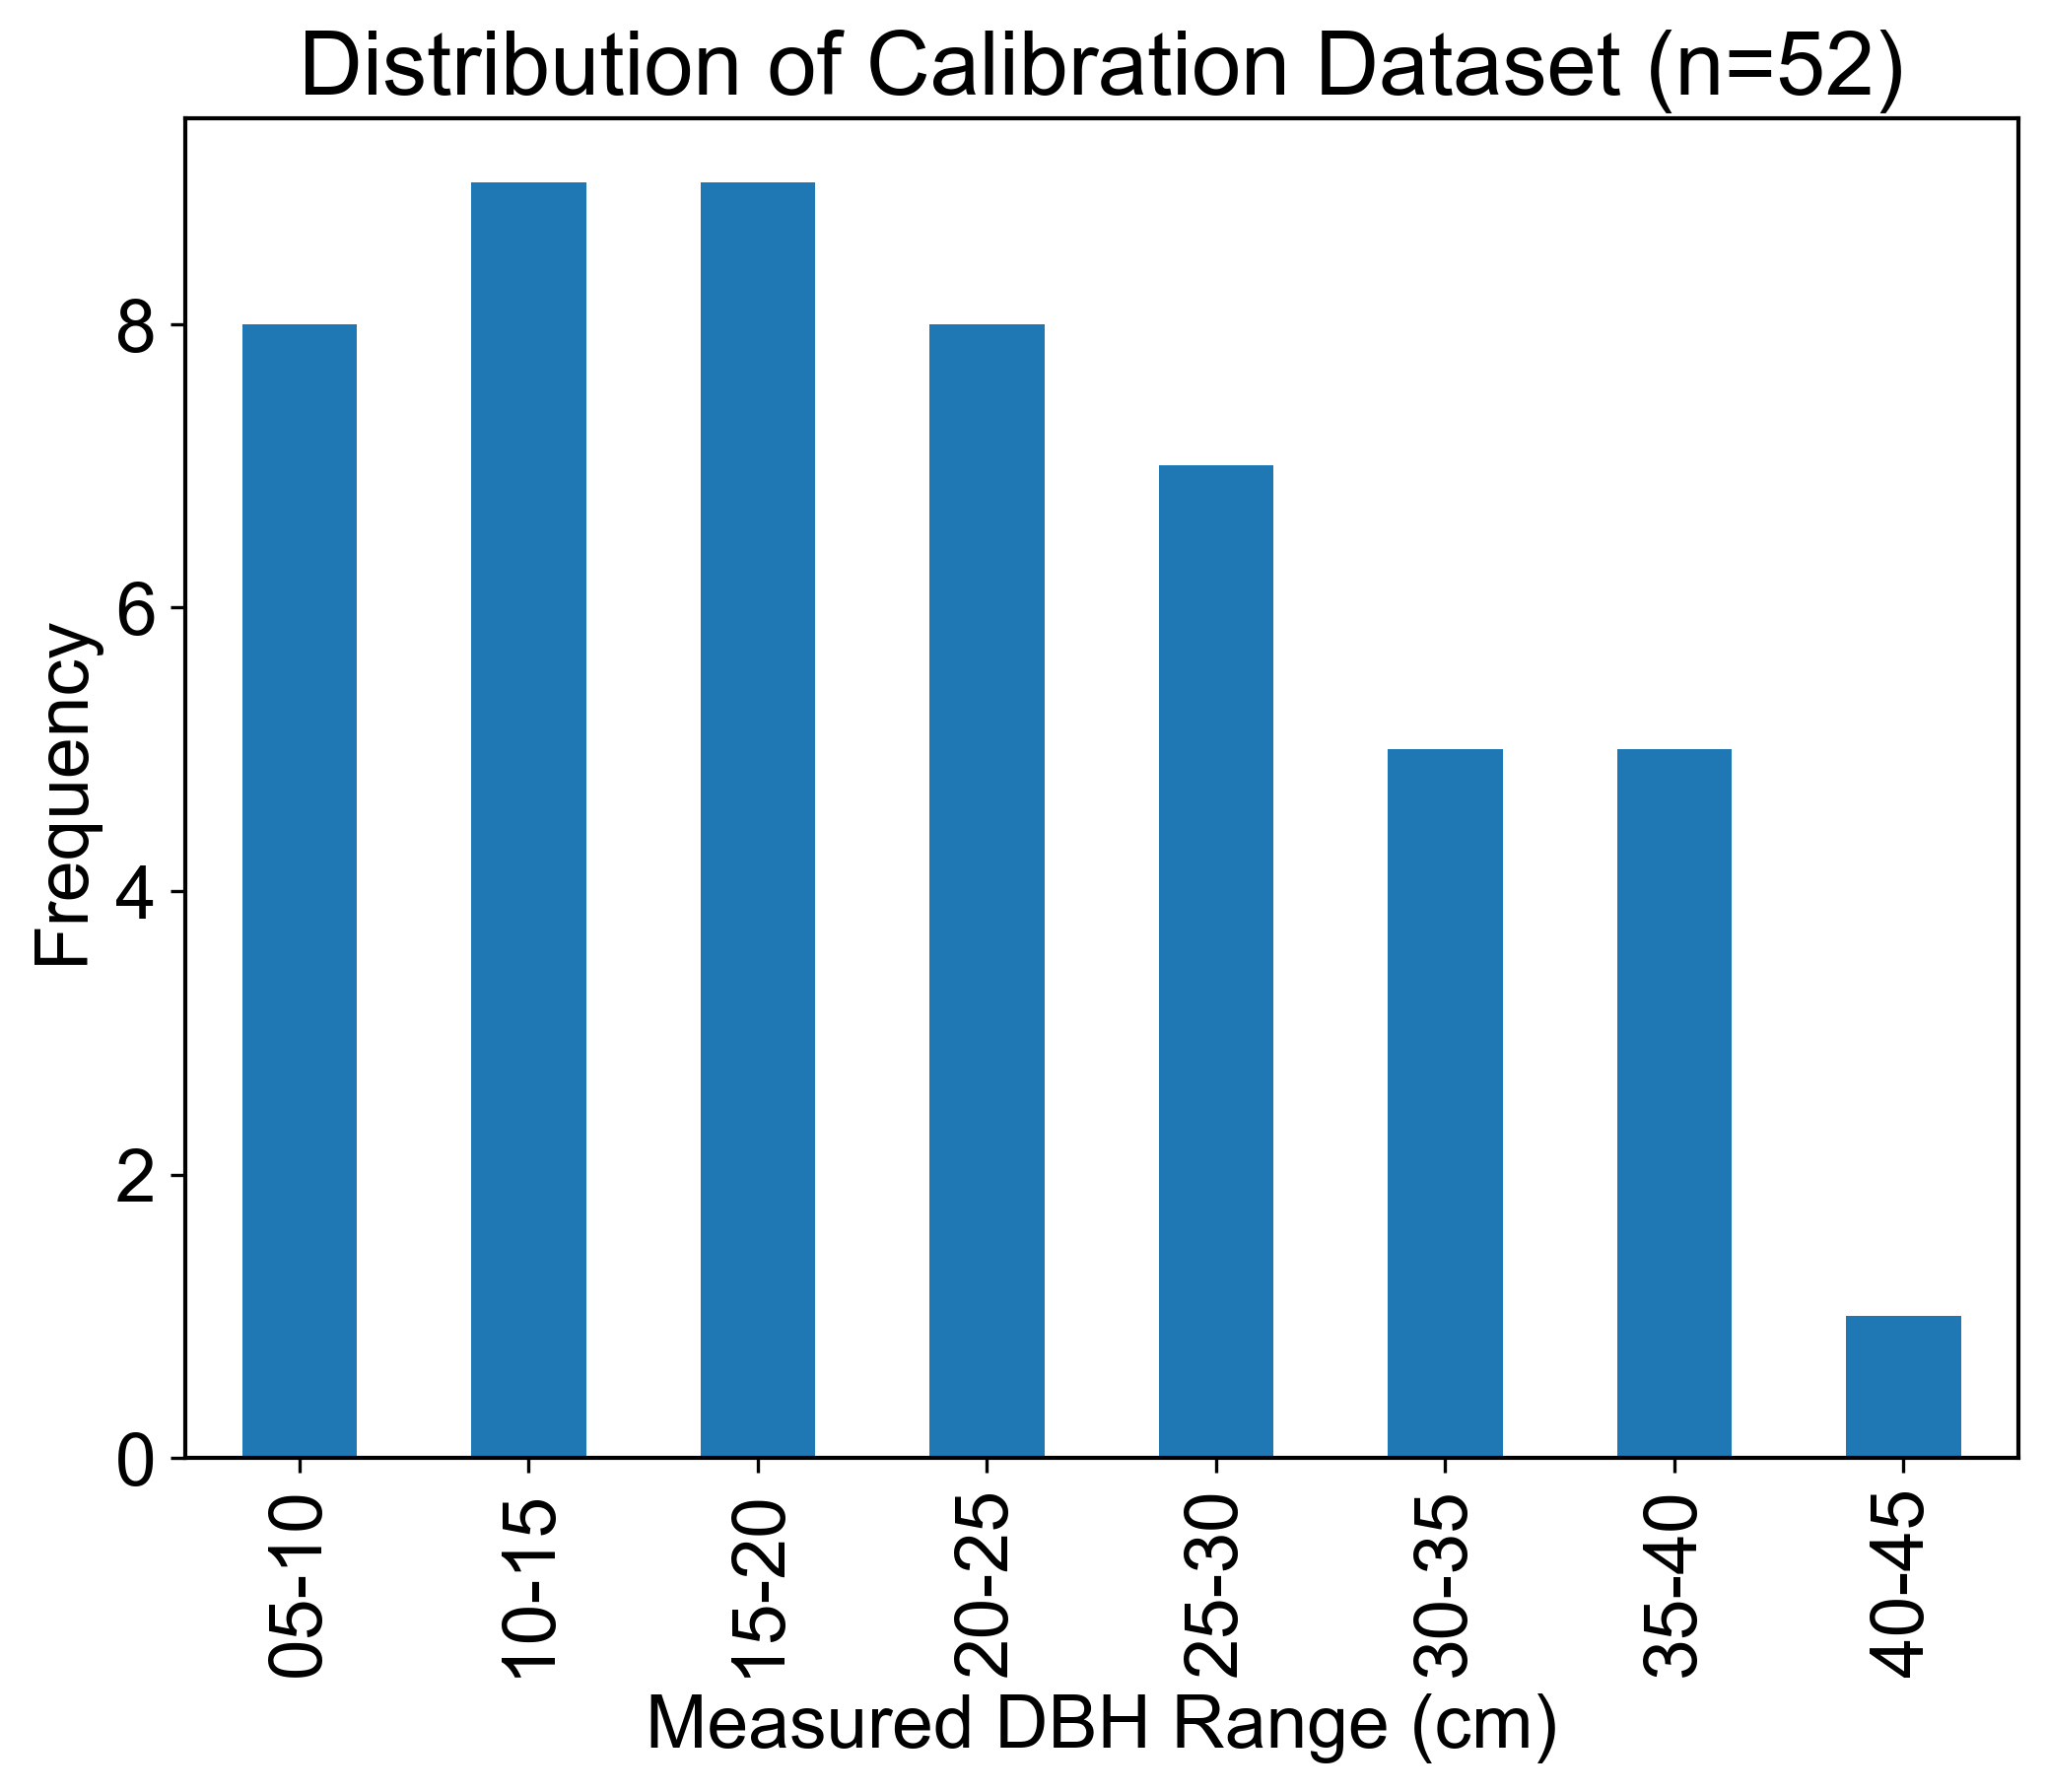

In [38]:
# Make a plot for the distribution of the calibration dataset
figure(figsize=(8, 6), dpi=300)
font = {'fontname':'Arial'}
t = df_sample[ df_sample["tree_picture"].apply(isCalibirationData)]
t.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Calibration Dataset (n={len(t)})', **font)
plt.xlabel("Measured DBH Range (cm)", **font)
plt.ylabel("Frequency", **font)

In [39]:
df_sample = df_sample[df_sample["tree_picture"].apply(isNotCalibirationData)] # filter out calibration dataset

In [40]:
# filter out dataset where measured dbh < 5
df_sample = df_sample[df_sample["measured_dbh"]>=5]
len(df_sample)

144

In [41]:
# Get dbh predictions for all dataset 
df_sample['predicted_dbh'] = df_sample.apply(lambda x: getDBH(x['image_path'], x['measured_dbh']), axis=1)

In [42]:
# function to check if a prediction was made 
def isfloat(x):
    return type(x) == float

In [43]:
# check that a prediction was made for each image
df_sample['calculated'] = df_sample['predicted_dbh'].apply(isfloat)

In [44]:
# count t
df_sample[df_sample['calculated'] == False].groupby('predicted_dbh').count()
# the algorithm made a prediction for all the images

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,calculated
predicted_dbh,,,,,,,,


In [45]:
df_sample[df_sample['calculated'] == False]

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,predicted_dbh,calculated


In [46]:
df1 = df_sample[df_sample['predicted_dbh'].apply(isfloat)]
#df1 = df1[df1['range'] != '0-05'] # remove less than 5 cm 
#df1 = df1[df1['range'] != '45+'] # remove above 45+ cm
len(df1)

144

In [47]:
# distribution of prediction dbh range
df1.groupby('range').count()

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,predicted_dbh,calculated
range,,,,,,,,
05-10,28,28,28,28,28,28,28,28
10-15,18,18,18,18,18,18,18,18
15-20,22,22,22,22,22,22,21,22
20-25,26,26,26,26,26,26,26,26
25-30,14,14,14,14,14,14,14,14
30-35,16,16,16,16,16,16,16,16
35-40,10,10,10,10,10,10,10,10
40-45,6,6,6,6,6,6,6,6
45+,4,4,4,4,4,4,4,4


In [48]:
# drop dataset with nan
df1 = df1.dropna()
len(df1)

143

In [49]:
# Calculate error percentage
def getErrorPercentage(predicted, measured):
    return (abs(predicted - measured)/measured) * 100

df1['Error_percentage'] = df1.apply(lambda x: getErrorPercentage(x['predicted_dbh'], x['measured_dbh']), axis=1)

In [50]:
# filter out dataset where trees were too small (i.e < 5cm)
df2 = df1[df1['measured_dbh'] > 5]
len(df1)

143

(array([103]),)


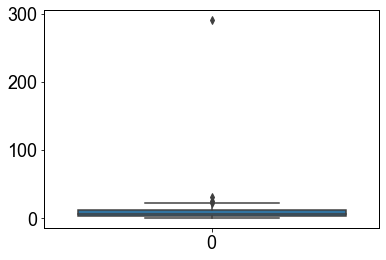

In [51]:
#Remove outliers based on box plot of Error percentage
sns.boxplot(df1['Error_percentage'].tolist())

df3 = df1#[df2['residuals'].apply(notOutlier)]

# Position of the Outlier
print(np.where(df1['Error_percentage']>40))

df3 = df1[df1['Error_percentage']<40]

In [52]:
# This image that was remove is one case where the data collected did no follow instructions. The image was taken very far from the tree. 
# The way in which this image was taken is not how the technology will be used in the field, hence we can justify removing this one outlier. 
df1[df1['Error_percentage']>40]

,tree_picture,image_path,tree_dbh,PARENT_KEY,tape,measured_dbh,range,predicted_dbh,calculated,Error_percentage
147,1675151881423.jpg,/Users/edwardamoah/Documents/GitHub/pv_mrv/sta...,9.2,uuid:5a1a3321-3df3-42e6-98d8-5b7e953d9cdc,diameter,9.2,05-10,35.93,True,290.543478


In [53]:
# calculate the RMSE and bias for the prediction
def calculateBias(pred, obs):
    return pred - obs

def calculateRMSE(pred, obs):

    return math.pow(calculateBias(pred,obs),2)

df3['rmse'] = df3.apply(lambda x: calculateRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
rmse =   math.sqrt(np.sum(df3['rmse'].tolist())/len(df3))
print(rmse)

df3['bias'] = df3.apply(lambda x: calculateBias(x['predicted_dbh'], x['measured_dbh']), axis=1)
bias = np.sum(df3['bias'].tolist())/len(df3)
print(bias)

2.2258114519694407
0.49394366197183087


/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_97170/1038417224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rmse'] = df3.apply(lambda x: calculateRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_97170/1038417224.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bias'] = df3.apply(lambda x: calculateBias(x['predicted_dbh'], x['measured_dbh']), axis=1)


In [54]:
from matplotlib.pyplot import figure

Text(2, 30, 'RMSE = 2.23 ')

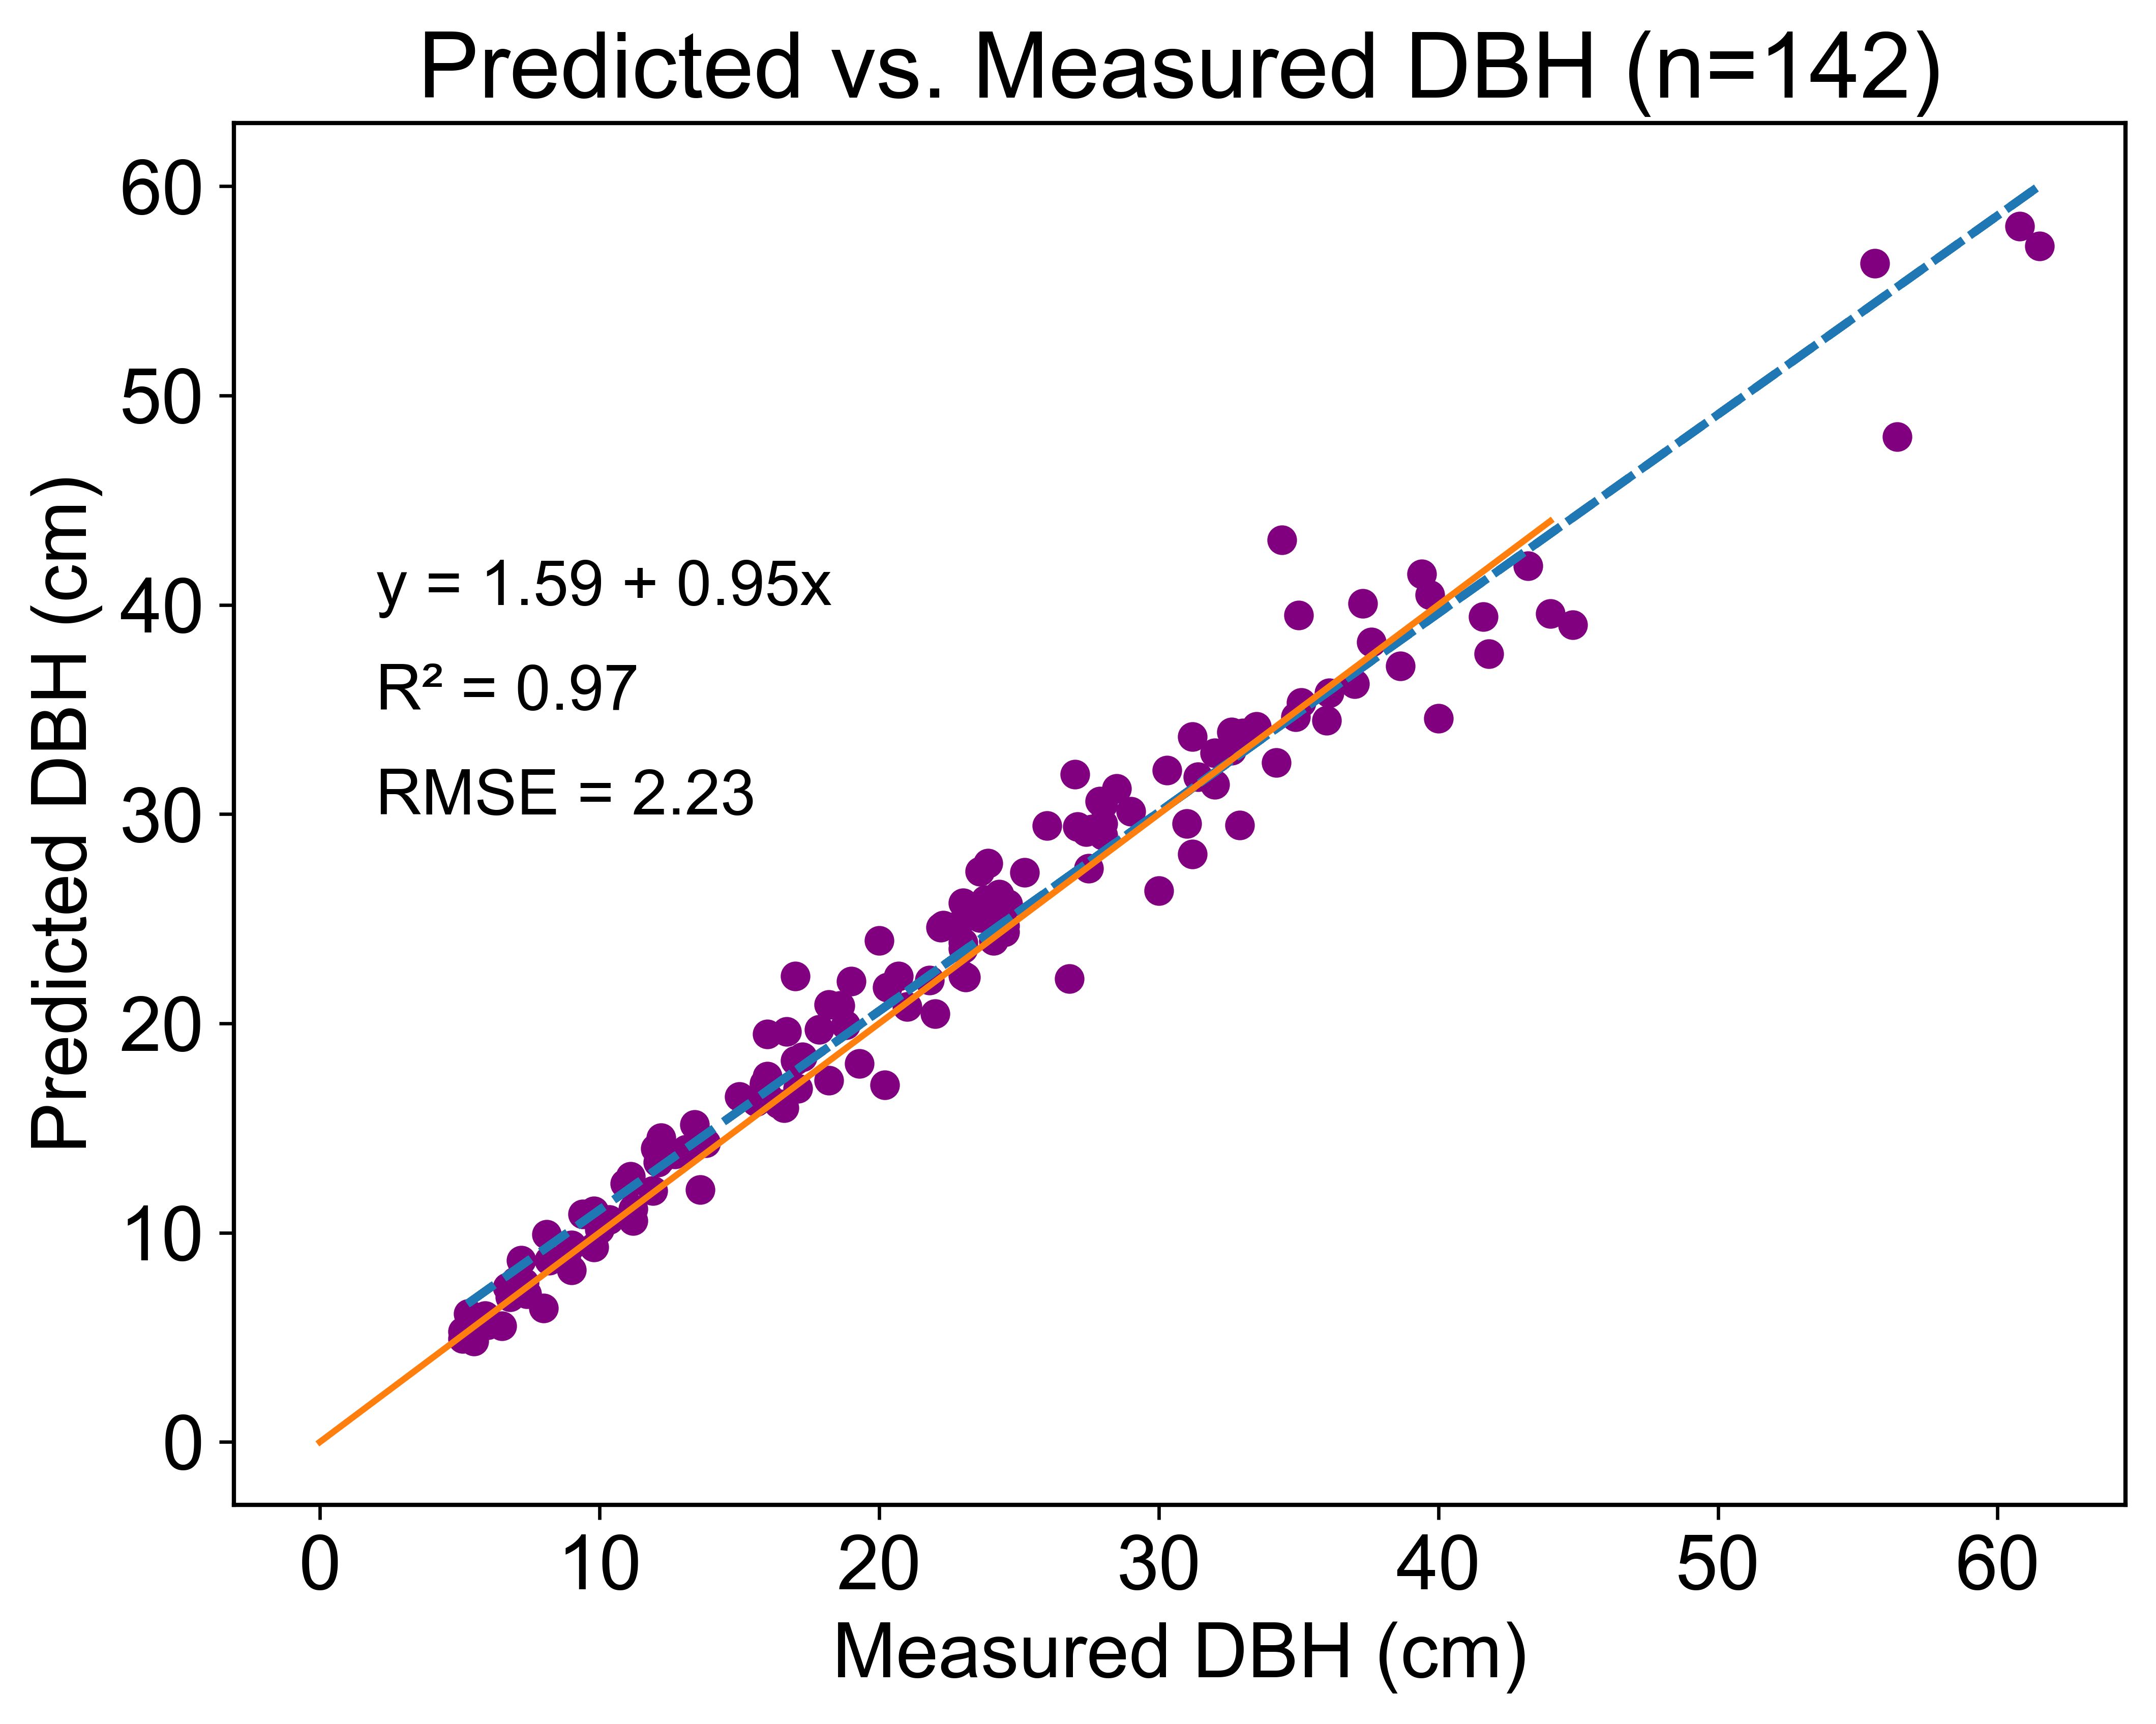

In [55]:
# make residual plot for the corelation between predicted and measure dbh values
x = np.array(df3['measured_dbh']); y = np.array( [ float(x) for x in df3['predicted_dbh']])
a, b = np.polyfit(x, y , 1)

figure(figsize=(8, 6), dpi=600)

# font 
font = {'fontname':'Arial'}


plt.scatter(x, y, color='purple')
plt.plot(x, a*x+b, linestyle='--', linewidth=2)
plt.plot(np.arange(45), np.arange(45))
plt.xlabel("Measured DBH (cm)", **font)
plt.ylabel("Predicted DBH (cm)", **font)
plt.title(f"Predicted vs. Measured DBH (n={len(df3)})", **font)

# add fitted regression equation to plot
plt.text(2, 40, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=15, **font)

# add the r2
plt.text(2,35, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=15, **font)

# add rmse
plt.text(2,30, f"RMSE = {round(rmse,2)} ", size=15, **font)

Text(0, 0.5, 'Frequency')

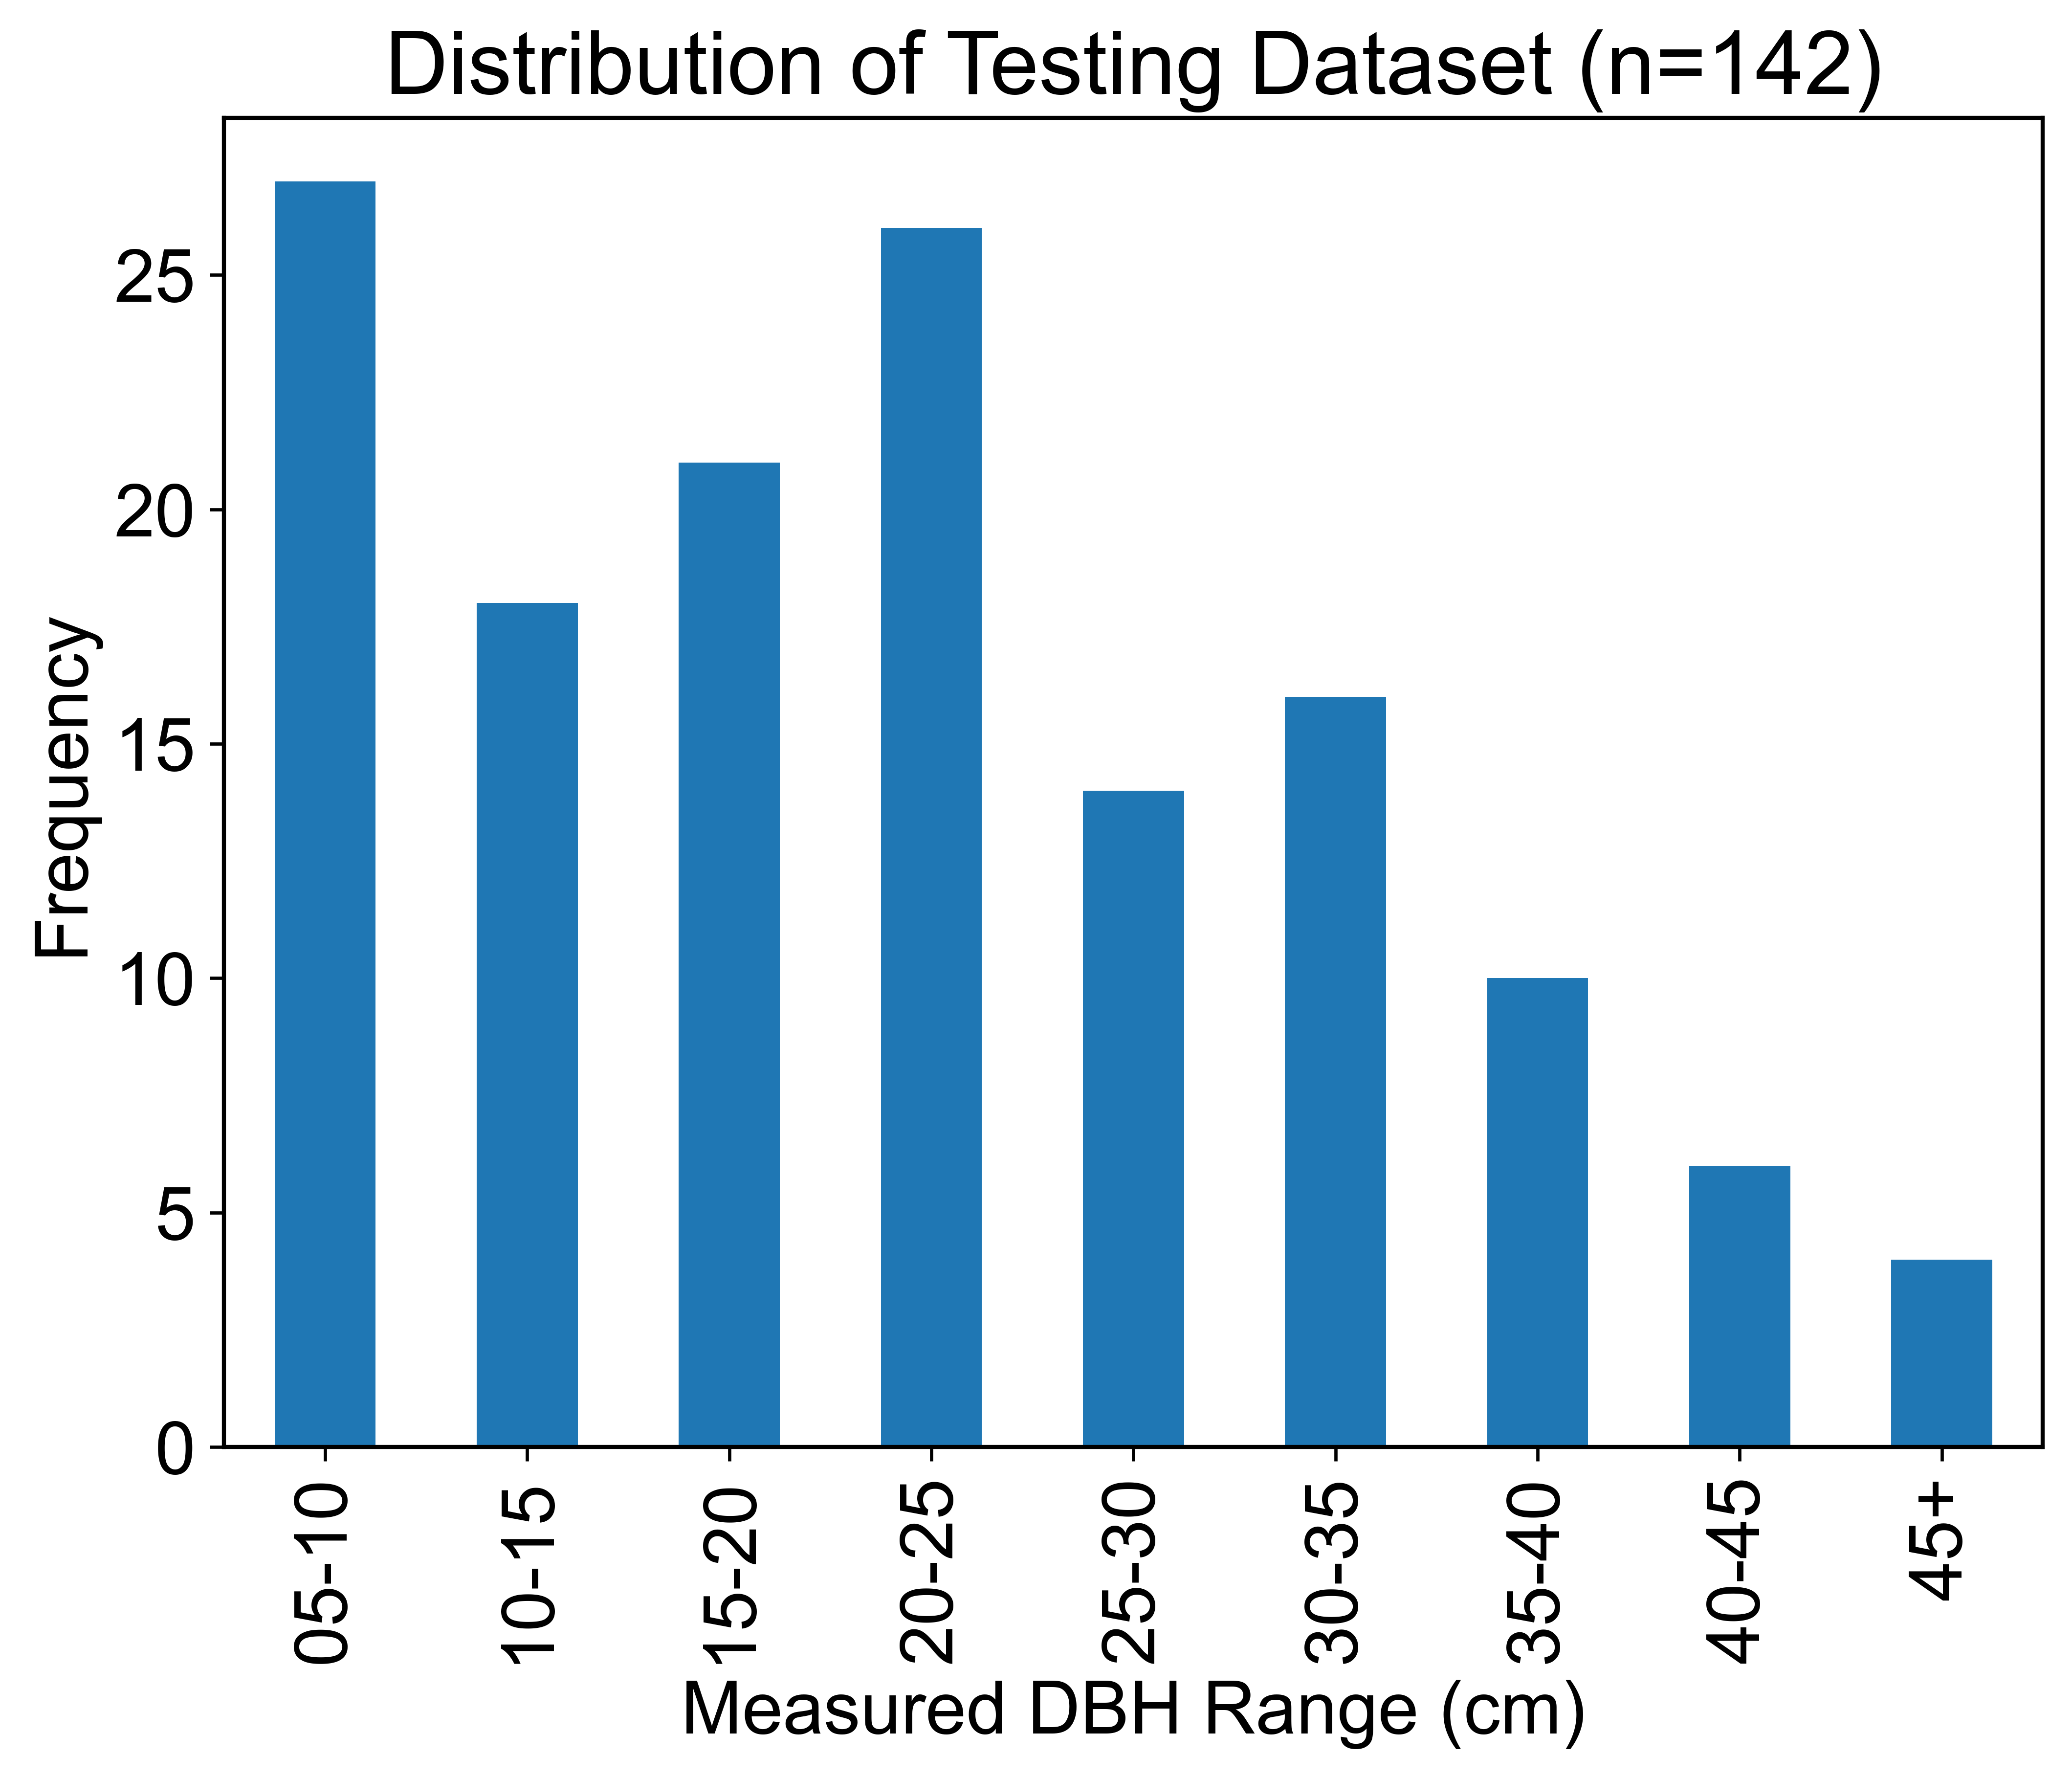

In [147]:
#Make a distribution plot for the dataset used for evaluation 
figure(figsize=(8, 6), dpi=600)
df3.groupby('range').count()['tree_picture'].plot.bar()
plt.title(f'Distribution of Testing Dataset (n={len(df3)})', **font)
plt.xlabel("Measured DBH Range (cm)", **font)
plt.ylabel("Frequency", **font)

In [56]:
#df3[["measured_dbh","predicted_dbh"]].to_csv("dbh_algorithm_evaluation_dataset.csv")

In [57]:
# make a standardize residual plot for the model prediction
df3['residuals'] = df3['predicted_dbh'] - df3['measured_dbh']
# calculating the standardized residuals

import statsmodels.api as sm

#define response variable
y = df3['predicted_dbh']
y = [int(v) for v in y]

#define explanatory variable
x = df3['measured_dbh']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 

#create instance of influence
influence = model.get_influence()

#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal


/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_97170/2259229101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['residuals'] = df3['predicted_dbh'] - df3['measured_dbh']


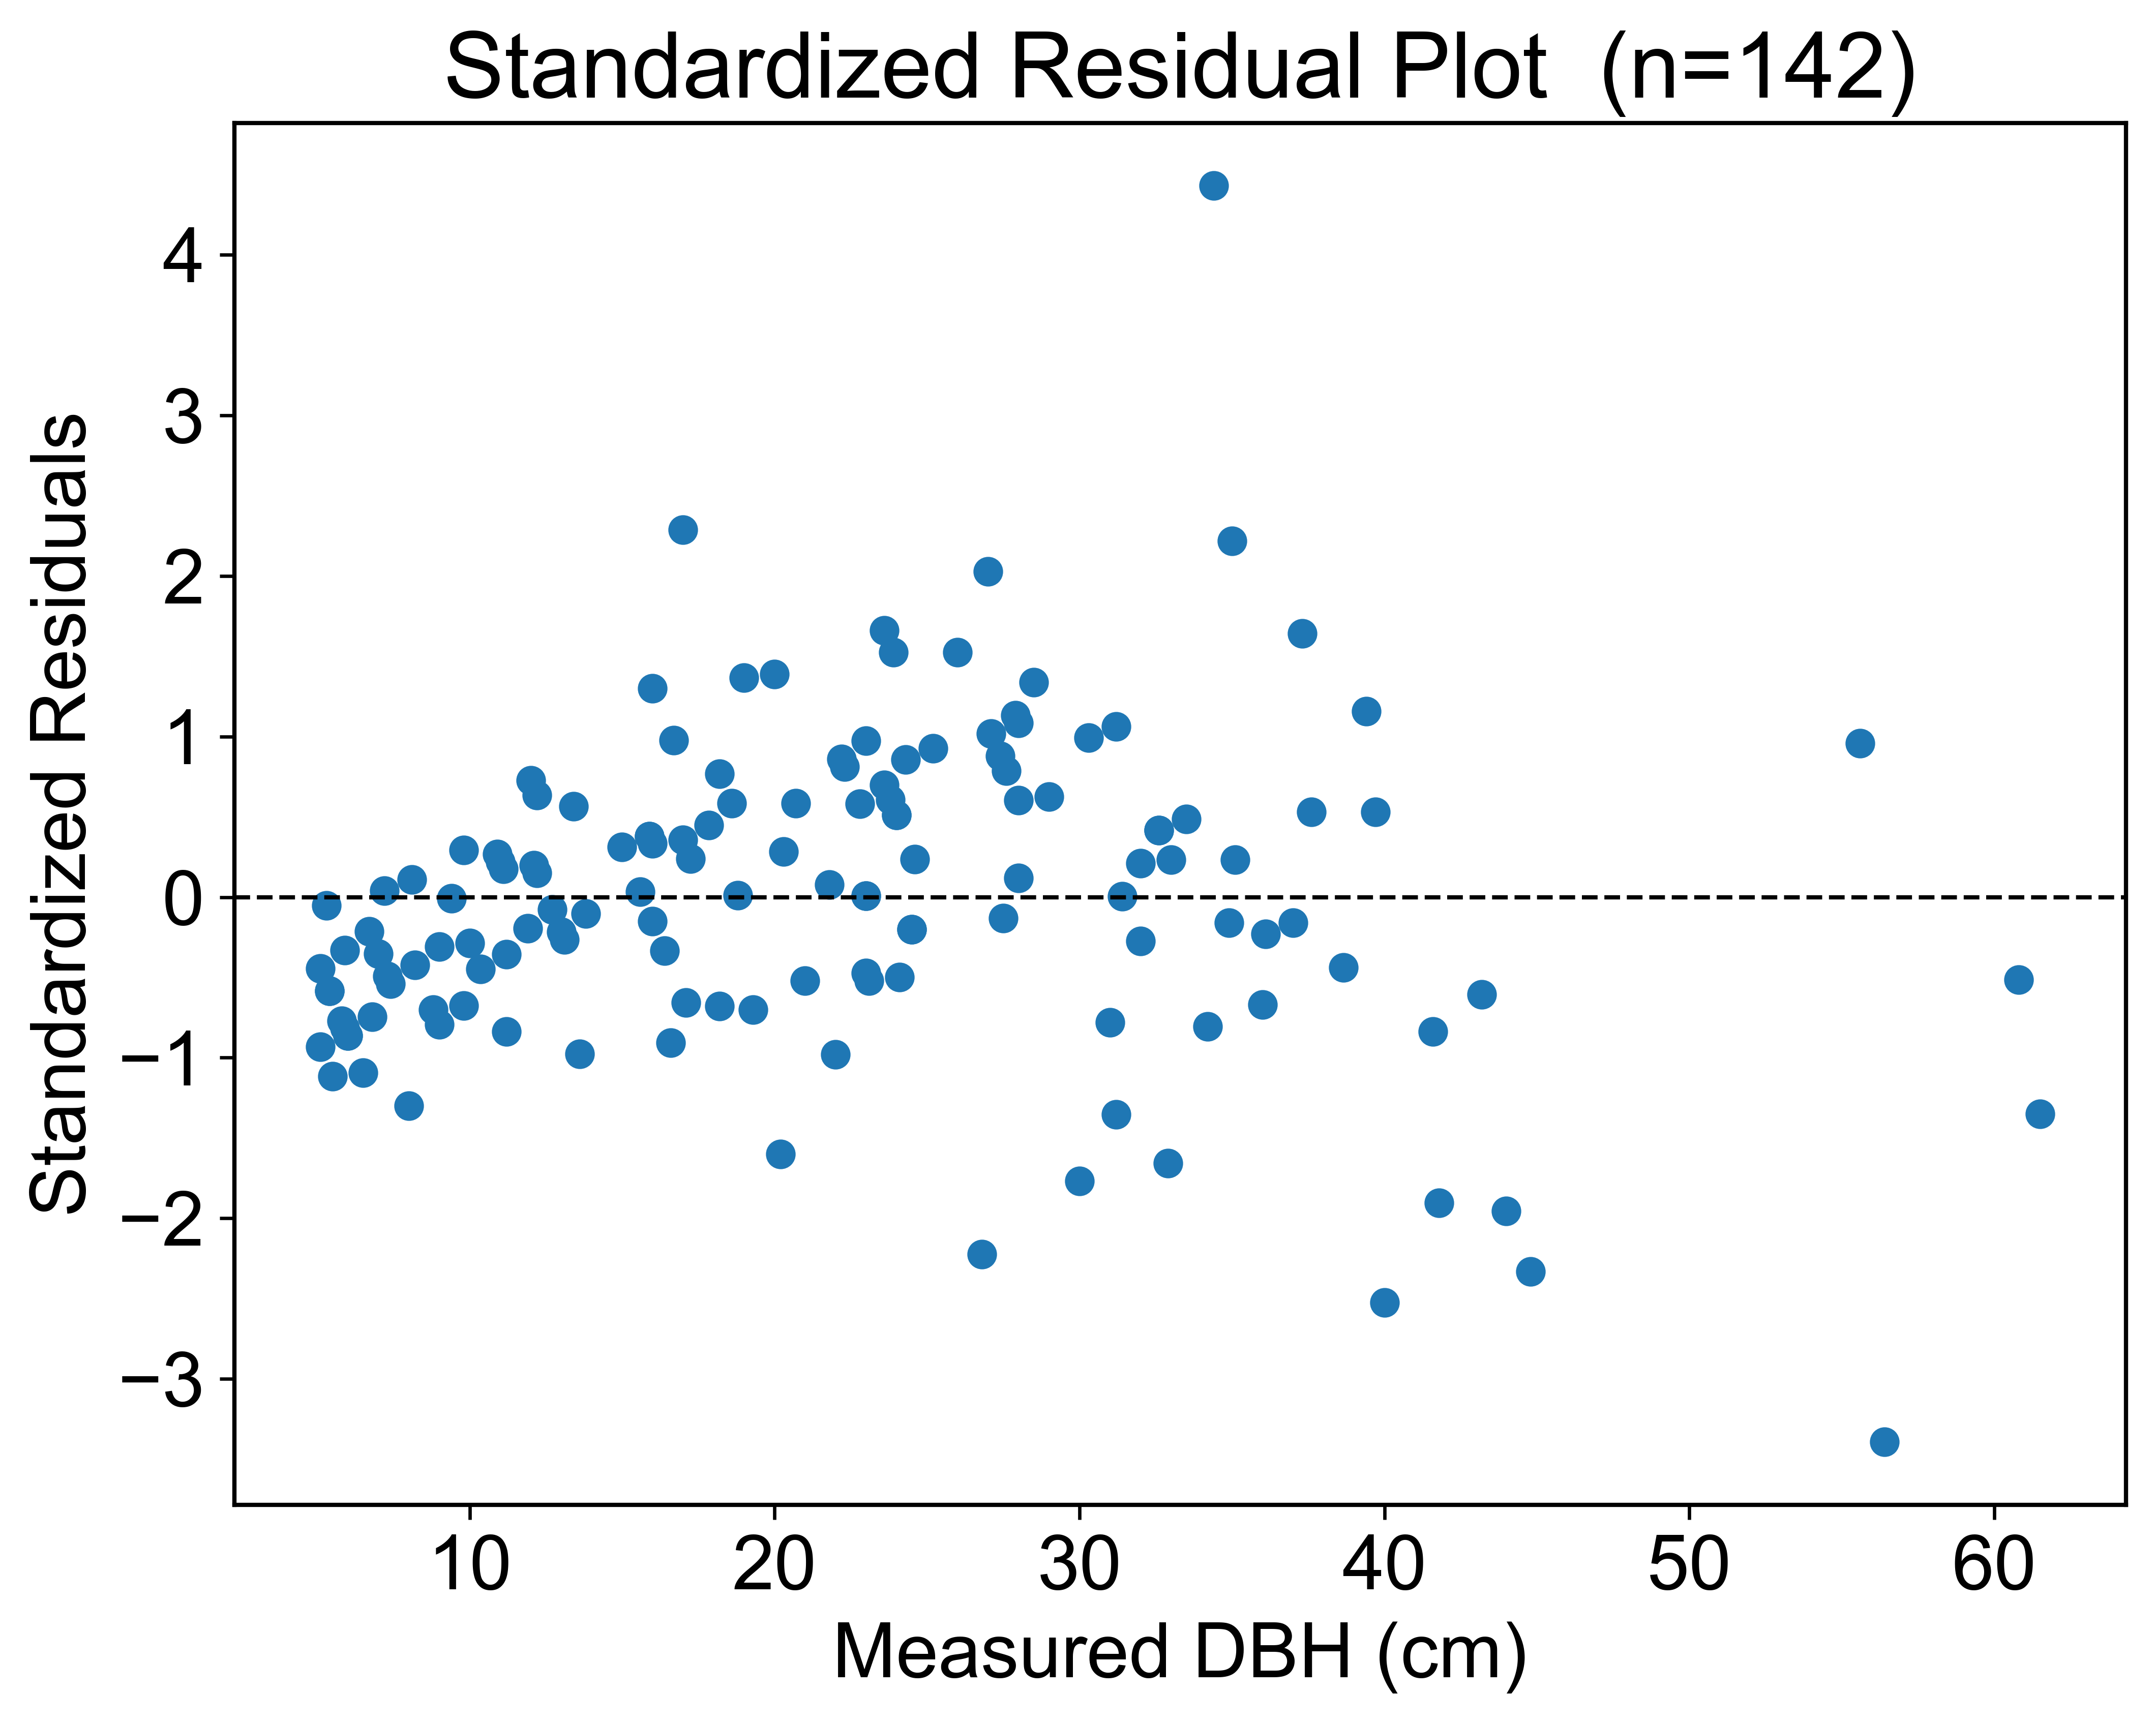

In [58]:
#plot standardized residual plot
figure(figsize=(8, 6), dpi=600)
plt.scatter(df3['measured_dbh'], standardized_residuals)
plt.xlabel('Measured DBH (cm)', **font)
plt.ylabel('Standardized Residuals', **font)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title(f"Standardized Residual Plot  (n={len(df3)})", **font)
plt.show()

In [59]:
# Make a regression model for predicted vs measured dbh values with statsmodels
import statsmodels.formula.api as smf


model = smf.ols('predicted_dbh ~ measured_dbh', data=df3)
model = model.fit()

In [60]:
# show model summary to get values for intercepts and significance at 0.05 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          predicted_dbh   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4294.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):          6.18e-107
Time:                        00:36:38   Log-Likelihood:                -305.78
No. Observations:                 142   AIC:                             615.6
Df Residuals:                     140   BIC:                             621.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5881      0.364      4.361      0.000       0.868       2.308
measured_dbh     0.9502      0.015     65.526      0.000       0.922       0.979
==============================================================================
Omnibus:                       12.301   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.937
Skew:                           0.133   Prob(JB):                     7.05e-08
Kurtosis:                       5.344   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# save evaluation dataset
#df3[["tree_picture","predicted_dbh","measured_dbh"]].to_csv("output/dbh_algorithm_evaluation_dataset.csv")

In [10]:
############### Data Evaluation Version 2 ###############

In [93]:
data = pd.read_csv("/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/output/dbh_algorithm_evaluation_dataset.csv")

In [94]:
def getRange(dbh):
    if dbh < 16:
        return "5.0-15.9"
    elif dbh < 26:
        return "16.0-25.9"
    elif dbh < 36:
        return "26.0-35.9"
    return "36+"

In [95]:
data["ranges"] = data.measured_dbh.apply(getRange)

In [96]:
data.groupby("ranges").count()

,Unnamed: 0,tree_picture,predicted_dbh,measured_dbh
ranges,,,,
16.0-25.9,44,44,44,44
26.0-35.9,31,31,31,31
36+,18,18,18,18
5.0-15.9,49,49,49,49


In [87]:
# normality test
#data.query(" ranges == '36+'")["bias"]

import scipy.stats as stats


def normalityTest(data):
    # Assuming 'data' is your dataset
    statistic, p_value = stats.shapiro(data)

    # Check if the data follows a normal distribution
    alpha = 0.05  # Significance level
    if p_value > alpha:
        print("Data looks normally distributed (fail to reject H0)")
        #print(p_value)
        #print(statistic)
    else:
        print("Data is not normal")
        #print(p_value)
        #print(statistic)

    return [p_value, statistic]

Data looks normally distributed (fail to reject H0)


In [100]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
def makeNormalityPlot(data):
    #data1 = data.query(" ranges == '36+'")["rel_bias"]

    # Create a normal probability plot
    stats.probplot(data, plot=plt)
    plt.title("Normal Probability Plot")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()


In [101]:
import scipy.stats as stats

def getStatisticalTest(data):
    # Perform a one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(data, 0)

    # Set your significance level (alpha)
    alpha = 0.05  # You can adjust this value based on your desired level of significance

    # Check if the mean is significantly different from zero
    if p_value < alpha:
        print("The mean of the dataset is significantly different from zero (reject H0)")
    else:
        print("The mean of the dataset is not significantly different from zero (fail to reject H0)")

    return [p_value, t_statistic]


In [98]:
df3 = data
# calculate the RMSE and BIAS for the prediction
def Bias(pred, obs):
    return pred - obs

def relBias(pred, obs):
    return (pred-obs)/obs

def RMSE(pred, obs):
    return math.pow(Bias(pred,obs),2)

def relRMSE(pred, obs):
    return math.pow(relBias(pred,obs),2)

df3['rmse'] = df3.apply(lambda x: RMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
rmse =   math.sqrt(np.sum(df3['rmse'].tolist())/len(df3))
print(rmse)

df3['rel_rmse'] = df3.apply(lambda x: relRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
rel_rmse =   math.sqrt(np.sum(df3['rel_rmse'].tolist())/len(df3)) * 100
print(rel_rmse)

df3['bias'] = df3.apply(lambda x: Bias(x['predicted_dbh'], x['measured_dbh']), axis=1)
bias = np.sum(df3['bias'].tolist())/len(df3)
print(bias)

df3['rel_bias'] = df3.apply(lambda x: relBias(x['predicted_dbh'], x['measured_dbh']), axis=1)
rel_bias = (np.sum(df3['rel_bias'].tolist())/len(df3)) * 100
print(rel_bias)

2.2258114519694407
9.79201702440032
0.49394366197183087
3.413130878271254


In [108]:
def getMetrics(df3):
    def Bias(pred, obs):
        return pred - obs

    def relBias(pred, obs):
        return (pred-obs)/obs

    def RMSE(pred, obs):
        return math.pow(Bias(pred,obs),2)

    def relRMSE(pred, obs):
        return math.pow(relBias(pred,obs),2)

    df3['rmse'] = df3.apply(lambda x: RMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
    rmse =   math.sqrt(np.sum(df3['rmse'].tolist())/len(df3))
    print(rmse)

    df3['rel_rmse'] = df3.apply(lambda x: relRMSE(x['predicted_dbh'], x['measured_dbh']), axis=1)
    rel_rmse =   math.sqrt(np.sum(df3['rel_rmse'].tolist())/len(df3)) * 100
    print(rel_rmse)

    df3['bias'] = df3.apply(lambda x: Bias(x['predicted_dbh'], x['measured_dbh']), axis=1)
    bias = np.sum(df3['bias'].tolist())/len(df3)
    print(bias)

    df3['rel_bias'] = df3.apply(lambda x: relBias(x['predicted_dbh'], x['measured_dbh']), axis=1)
    rel_bias = (np.sum(df3['rel_bias'].tolist())/len(df3)) * 100
    print(rel_bias)

    return [round(bias,3), round(rel_bias,3), round(rmse,3), round(rel_rmse,3)]
    

<AxesSubplot: xlabel='ranges', ylabel='bias'>

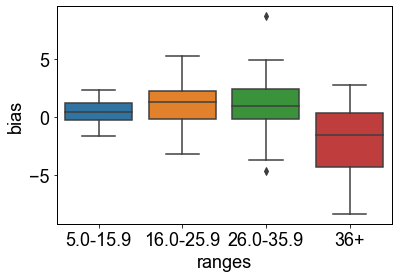

In [66]:
sns.boxplot(x="ranges", y="bias", data=df3, order=['5.0-15.9','16.0-25.9', '26.0-35.9', '36+'])

<AxesSubplot: xlabel='ranges', ylabel='rel_bias'>

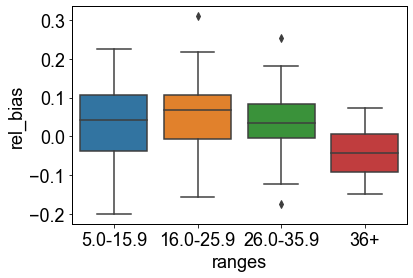

In [72]:
sns.boxplot(x="ranges", y="rel_bias", data=df3, order=['5.0-15.9','16.0-25.9', '26.0-35.9', '36+'])
#plt.xticks(rotaion=45)

In [113]:
getMetrics(data)

2.2258114519694407
9.79201702440032
0.49394366197183087
3.413130878271254


[0.494, 3.413, 2.226, 9.792]

In [114]:
len(data)

142

In [1]:
################### State College Proof of Concept #####################

In [7]:
tape = "standard"
def getMeasuredDBH(tree_dbh, tape):
    if tape == 'diameter':
        return tree_dbh
    elif tape == 'standard':
        return round(tree_dbh/math.pi, 2)
    else:
        return None
    

In [9]:
tree1 = getMeasuredDBH(8.3, tape)
tree2 = getMeasuredDBH(14.9, tape)
tree3 = getMeasuredDBH(30.3, tape)
tree4 = getMeasuredDBH(61.7, tape)
tree5 = getMeasuredDBH(54.2, tape)
tree6 = getMeasuredDBH(33.9, tape)
tree7 = getMeasuredDBH(34.8, tape)

In [10]:
images = "/Users/edwardamoah/Desktop/concept_proof/measurements"

In [14]:
df = pd.DataFrame({
    "file": [file for file in os.listdir(images) if "jpeg" in file]
}) 
#[file for file in os.listdir(images) if "jpeg" in file]

In [15]:
df['image_path'] = df.apply(lambda x: os.path.join(images, x['file']), axis=1)  

In [23]:
def getDiameter(file):
    tree = file.split("_")[1]
    if tree == '1':
        return tree1
    elif tree == '2':
        return tree2
    elif tree == '3':
        return tree3
    elif tree == '4':
        return tree4
    elif tree == '5':
        return tree5
    elif tree == '6':
        return tree6
    elif tree == '7':
        return tree7
    else:
        return None

In [24]:
df['measured_dbh'] = df.apply(lambda x: getDiameter(x['file']), axis=1)

In [27]:
df["predicted_dbh"] = df.apply(lambda x: getDBH(x['image_path'], x['measured_dbh']), axis=1)

In [35]:
df1 = df.query(' predicted_dbh != "No tag detected" ')

In [36]:
from sklearn.metrics import r2_score

# Assuming you have the actual values in the `y_true` variable and the predicted values in the `y_pred` variable
r2 = r2_score(df1["measured_dbh"], df1["predicted_dbh"])
print("R2 Score:", r2)


R2 Score: 0.7566413695089935


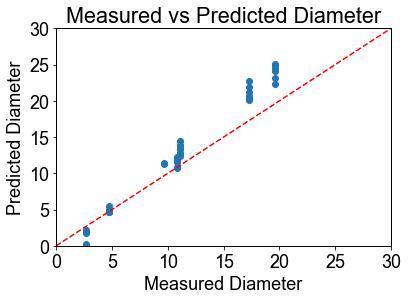

In [51]:
plt.scatter(df1["measured_dbh"], df1["predicted_dbh"])
plt.plot([0, 30], [0, 30], color='red', linestyle='--')
plt.xlabel("Measured Diameter")
plt.ylabel("Predicted Diameter")
plt.title("Measured vs Predicted Diameter")
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()


In [191]:
from PIL import Image, ImageSequence

# List of image file paths
#image_paths = df["image_path"].tolist() #["image1.png", "image2.png", "image3.png"]
image_paths = [os.path.join("/Users/edwardamoah/Desktop/concept_proof/overlay", file) for file in  os.listdir("/Users/edwardamoah/Desktop/concept_proof/overlay")]

image_paths = [f for f in image_paths if ".png" in f]

# Open the first image to get its size
first_image = Image.open(image_paths[0])
width, height = first_image.size

# Create a new GIF file
output_gif_path = "state_college_experiment.gif"
gif_frames = []

# Loop through each image and add it to the list of frames
for image_path in image_paths:
    img = Image.open(image_path)
    gif_frames.append(img)

# Save the frames as a GIF
gif_frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=gif_frames[1:],
    duration=1500,  # Duration between frames in milliseconds
    loop=0  # 0 means loop forever, any other value means loop that many times
)

print(f"GIF saved at: {output_gif_path}")


GIF saved at: state_college_experiment.gif


In [144]:
path = "/Users/edwardamoah/Downloads/Photos-001"

In [145]:
p = os.listdir(path)

In [146]:
p.sort()

In [147]:
p # confirm that the images are in order

['.DS_Store',
 'PXL_20231202_184002374_C_133.1_.jpg',
 'PXL_20231202_184051966.jpg',
 'PXL_20231202_184057383.jpg',
 'PXL_20231202_184117460.jpg',
 'PXL_20231202_184409193_C_48.1_.jpg',
 'PXL_20231202_184445565.jpg',
 'PXL_20231202_184448220.jpg',
 'PXL_20231202_184456382.jpg',
 'PXL_20231202_184502203.jpg',
 'PXL_20231202_184616906_C_48.2_.jpg',
 'PXL_20231202_184657854.jpg',
 'PXL_20231202_184700014.jpg',
 'PXL_20231202_184711422.jpg',
 'PXL_20231202_184713432.jpg',
 'PXL_20231202_184715316.jpg',
 'PXL_20231202_185510680_C_130_.jpg',
 'PXL_20231202_185637802.jpg',
 'PXL_20231202_185642615.jpg',
 'PXL_20231202_185645785.jpg',
 'PXL_20231202_185648432.jpg',
 'PXL_20231202_185651965.jpg',
 'PXL_20231202_185810533_C_137.5_.jpg',
 'PXL_20231202_185841912.jpg',
 'PXL_20231202_185843249.jpg',
 'PXL_20231202_185844533.jpg',
 'PXL_20231202_185846063.MP.jpg',
 'PXL_20231202_185847323.jpg',
 'PXL_20231202_185848695.jpg',
 'PXL_20231202_185849998.jpg',
 'PXL_20231202_190013845_C_81_.jpg',
 'PXL_

In [148]:
len([f for f in os.listdir(path) if "C" in f])

40

In [149]:
measurement = [f for f in os.listdir(path) if "C" in f]

In [150]:
def getIndex(file, p):
    return p.index(file)

In [151]:
df = pd.DataFrame({
    "file": measurement
})

In [152]:
df["idx"] = df.apply(lambda x: getIndex(x['file'], p), axis=1)

In [153]:
df.sort_values(by=['idx'], inplace=True)

In [154]:
d = np.diff(df["idx"].tolist())

In [155]:
d1 = []
for r in d:
    d1.append(r)

In [156]:
d1

[4,
 5,
 6,
 6,
 8,
 8,
 7,
 7,
 6,
 8,
 7,
 8,
 7,
 8,
 8,
 6,
 7,
 7,
 8,
 6,
 8,
 8,
 7,
 10,
 9,
 9,
 7,
 8,
 6,
 8,
 8,
 6,
 8,
 7,
 9,
 8,
 8,
 7,
 8]

In [158]:
#d1.append(len(p)-df["idx"].tolist()[-1])

In [159]:
df["range"] = d1

In [160]:
df["range"] = df["range"]-1

In [161]:
df["start"] = df["idx"] + 1
df["end"] = df["idx"] + df["range"]

In [162]:
tape = "standard"
def getMeasuredDBH(tree_dbh, tape):
    if tape == 'diameter':
        return tree_dbh
    elif tape == 'standard':
        return round(tree_dbh/math.pi, 2)
    else:
        return None

In [163]:
def getCircum(filename):
    return float(filename.split("_")[4])

In [164]:
df["circum"] = df.apply(lambda x: getCircum(x['file']), axis=1)

In [165]:
df["diameter"] = df.apply(lambda x: getMeasuredDBH(x['circum'], tape), axis=1)

In [166]:
df.head()

,file,idx,range,start,end,circum,diameter
5,PXL_20231202_184002374_C_133.1_.jpg,1,3,2,4,133.1,42.37
0,PXL_20231202_184409193_C_48.1_.jpg,5,4,6,9,48.1,15.31
8,PXL_20231202_184616906_C_48.2_.jpg,10,5,11,15,48.2,15.34
19,PXL_20231202_185510680_C_130_.jpg,16,5,17,21,130.0,41.38
10,PXL_20231202_185810533_C_137.5_.jpg,22,7,23,29,137.5,43.77


In [192]:
df.describe()

,idx,range,start,end,circum,diameter
count,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000
mean,138.450000,6.400000,139.450000,144.850000,80.55500,25.641000
std,87.578229,1.236206,87.578229,88.169868,38.98279,12.408641
min,1.000000,3.000000,2.000000,4.000000,24.90000,7.930000
25%,64.000000,6.000000,65.000000,70.250000,45.87500,14.600000
50%,135.000000,7.000000,136.000000,141.000000,67.85000,21.600000
75%,212.000000,7.000000,213.000000,219.000000,121.65000,38.720000
max,287.000000,9.000000,288.000000,296.000000,149.20000,47.490000


In [167]:
data = pd.DataFrame({
    "images": p
})

In [168]:
data.head()

,images
0,.DS_Store
1,PXL_20231202_184002374_C_133.1_.jpg
2,PXL_20231202_184051966.jpg
3,PXL_20231202_184057383.jpg
4,PXL_20231202_184117460.jpg


In [169]:
data["diameter"] = 0

for index, row in df.iterrows():
    start = row["start"]
    end = row["end"]
    diameter = row["diameter"]
    
    data.loc[start:end, "diameter"] = diameter


In [170]:
dataset = data.query(" diameter != 0 ")

In [171]:
image_path = "/Users/edwardamoah/Downloads/Photos-001"
def getImagePath(filename):
    return os.path.join(image_path, filename)

dataset["image_path"] = dataset.apply(lambda x: getImagePath(x['images']), axis=1)

/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_29643/3425092235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["image_path"] = dataset.apply(lambda x: getImagePath(x['images']), axis=1)


In [172]:
dataset["predicted_dbh"] = dataset.apply(lambda x: getDBH(x['image_path'], x['diameter']), axis=1)

/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_29643/1217340070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["predicted_dbh"] = dataset.apply(lambda x: getDBH(x['image_path'], x['diameter']), axis=1)


In [173]:
dataset = dataset[dataset["predicted_dbh"] != "No tag detected"]

In [174]:
dataset

,images,diameter,image_path,predicted_dbh
2,PXL_20231202_184051966.jpg,42.37,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,39.07
3,PXL_20231202_184057383.jpg,42.37,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,44.08
4,PXL_20231202_184117460.jpg,42.37,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,42.22
6,PXL_20231202_184445565.jpg,15.31,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,17.55
7,PXL_20231202_184448220.jpg,15.31,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,17.91
...,...,...,...,...
292,PXL_20231202_200843161.jpg,20.21,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,21.02
293,PXL_20231202_200844854.jpg,20.21,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,22.32
294,PXL_20231202_200847337.jpg,20.21,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,22.20
295,PXL_20231202_200850156.jpg,20.21,/Users/edwardamoah/Downloads/Photos-001/PXL_20...,21.79


In [187]:
# remove outliers
dataset1 = dataset[dataset["predicted_dbh"] < 60]

In [193]:
len(dataset1)

254

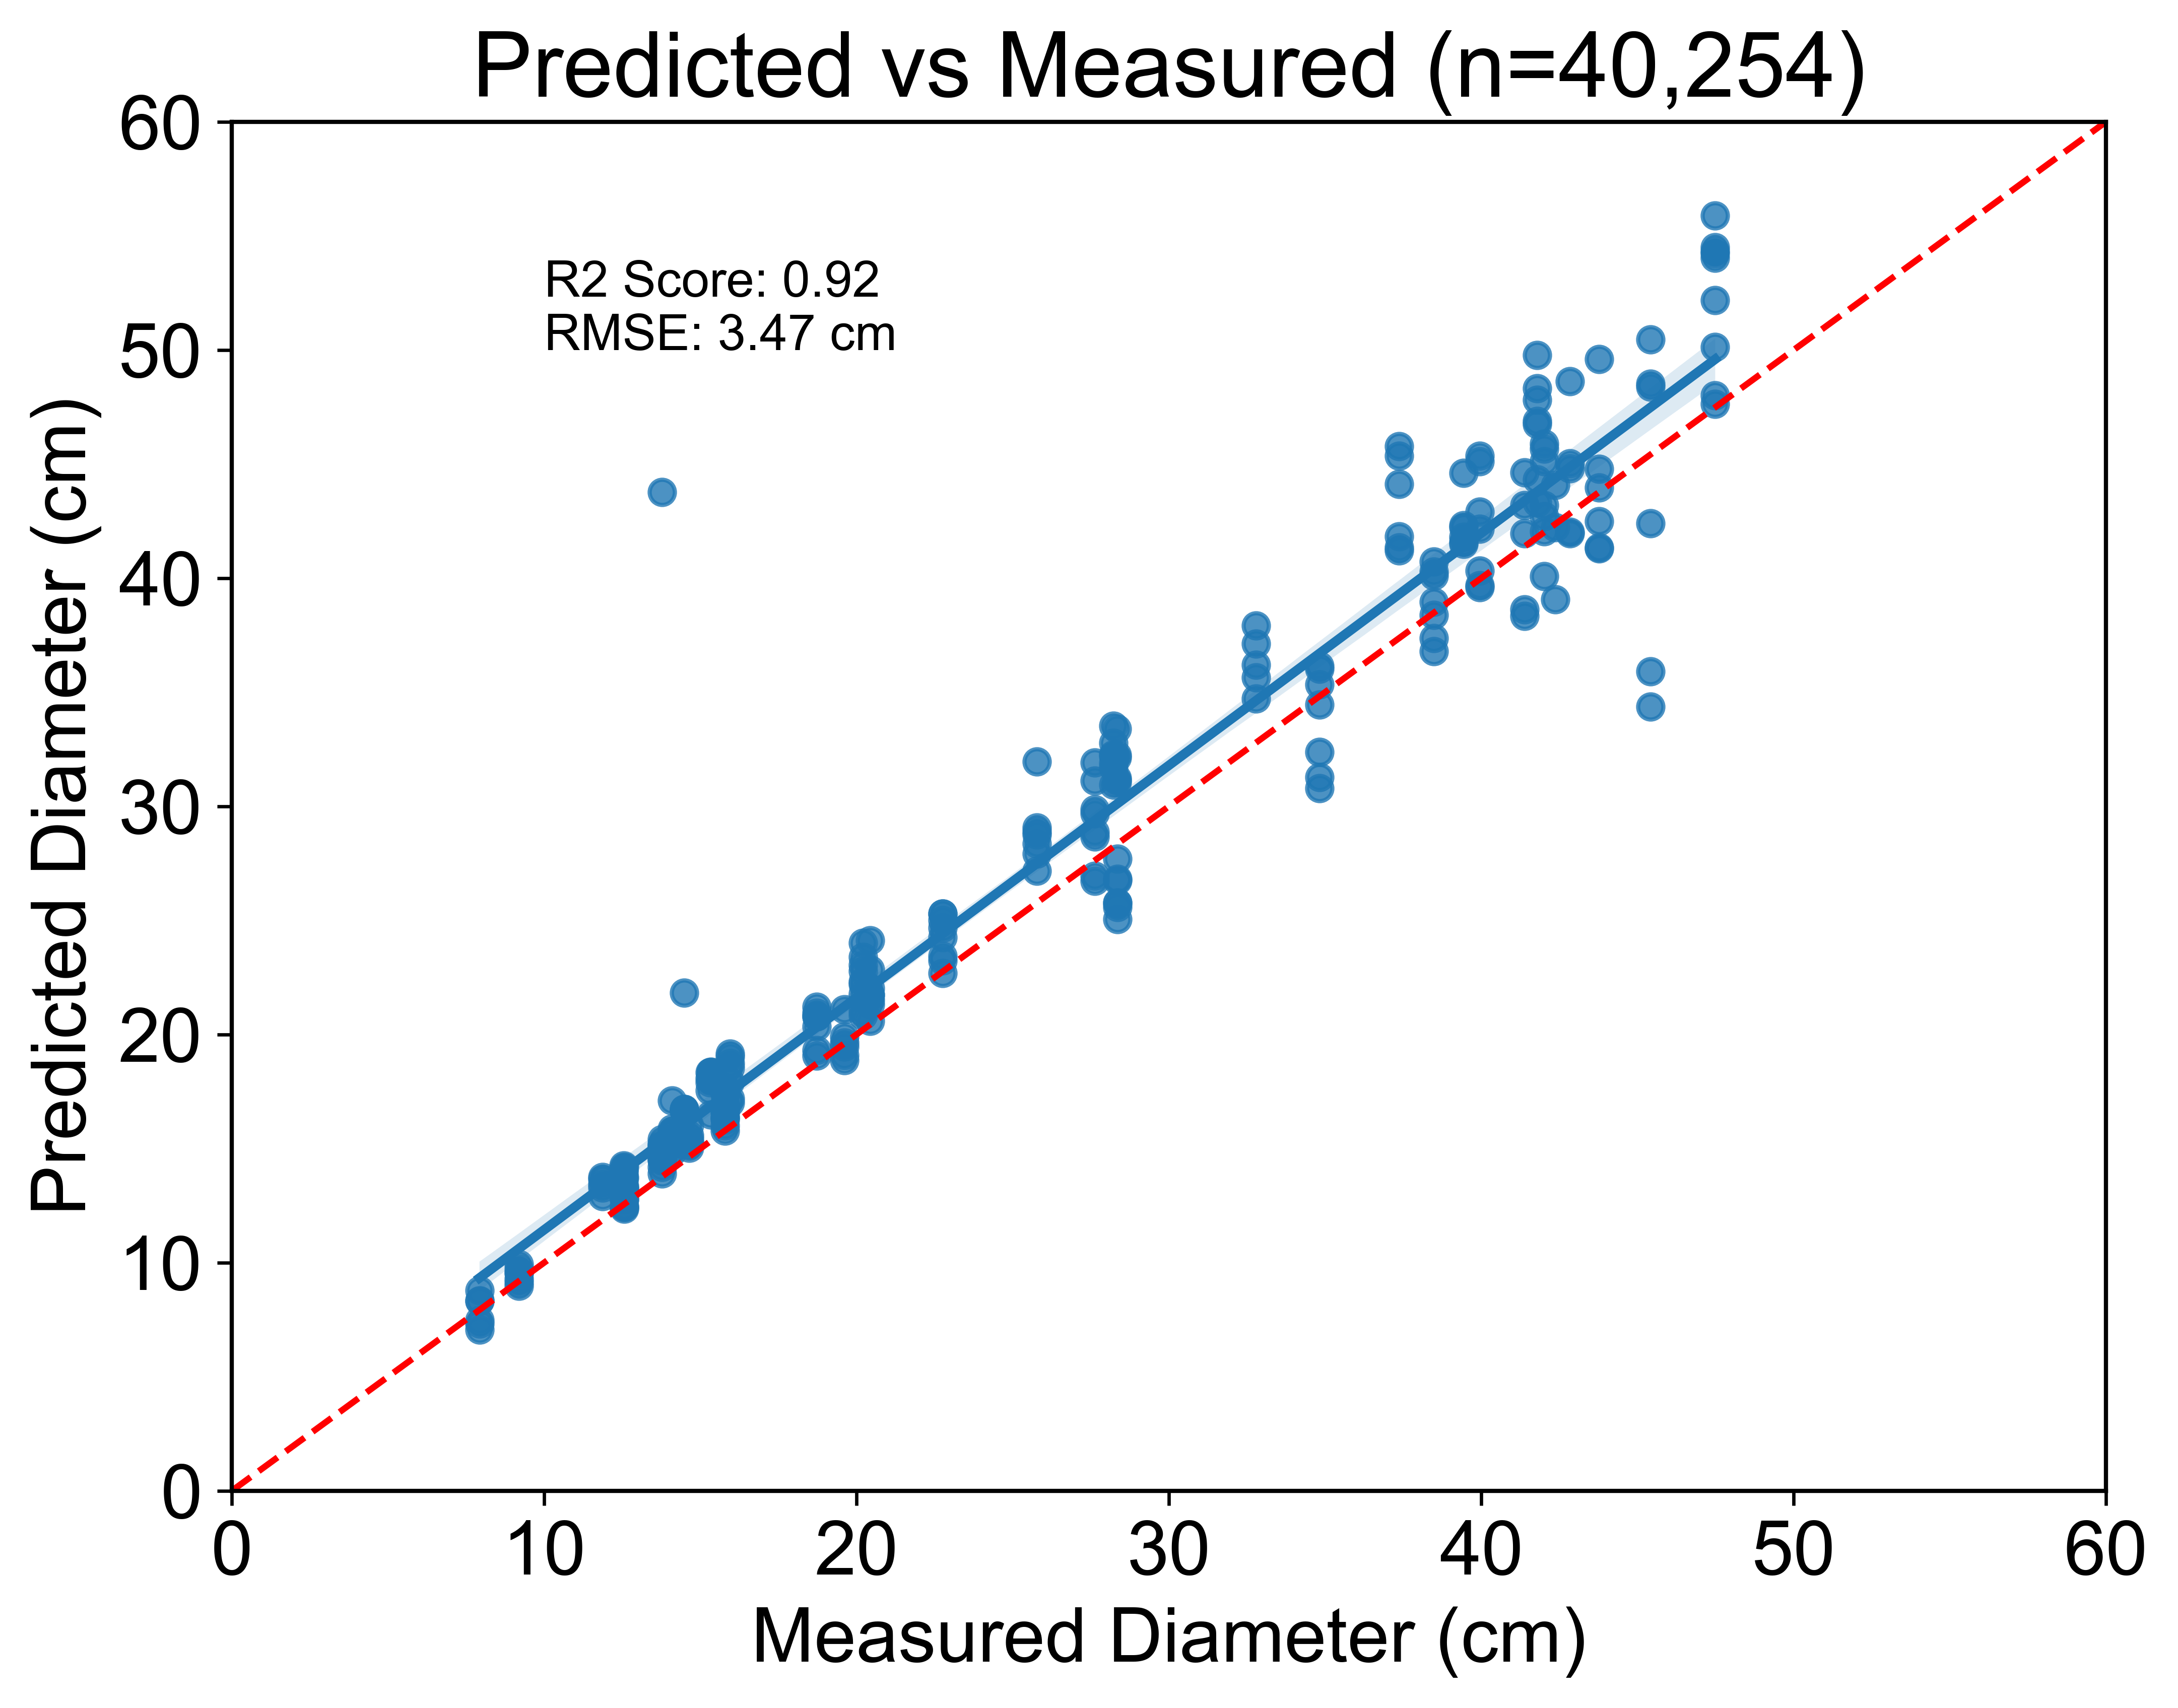

In [198]:
from sklearn.metrics import r2_score, mean_squared_error

figure(figsize=(8, 6), dpi=600)
sns.regplot(x=dataset1["diameter"], y=dataset1["predicted_dbh"])
plt.plot([0, 60], [0, 60], color='red', linestyle='--')

# Calculate R2 score
r2 = r2_score(dataset1["diameter"], dataset1["predicted_dbh"])

# Calculate RMSE
rmse = mean_squared_error(dataset1["diameter"], dataset1["predicted_dbh"], squared=False)

plt.text(10, 50, f"R2 Score: {r2:.2f}\nRMSE: {rmse:.2f} cm", fontsize=12)

plt.xlabel("Measured Diameter (cm)")
plt.ylabel("Predicted Diameter (cm)")
plt.title("Predicted vs Measured (n=40,254)")
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.show()

In [195]:
len(measurement)

40

In [196]:
from sklearn.metrics import r2_score

# remove outliers
dataset1 = dataset[dataset["predicted_dbh"] < 60]

# Assuming you have the actual values in the `y_true` variable and the predicted values in the `y_pred` variable
r2 = r2_score(dataset1["diameter"], dataset1["predicted_dbh"])
print("R2 Score:", r2)


R2 Score: 0.9176838609555849
